In [ ]:
train_set_split_kata = 'F:/embryo_dataset/train.txt'
val_set_split_kata = 'F:/embryo_dataset/val.txt'
with open(train_set_split_kata, 'r', encoding='utf-8') as f:
    train_lines = f.readlines()

with open(val_set_split_kata, 'r', encoding='utf-8') as f:
    val_lines = f.readlines()

In [ ]:
new_train_lines = [new_line.replace('/mnt/disk_2/AI03/phuc-lm/CleavageEmbryov1/combine_images/','F:/embryo_dataset/combine_images/') for new_line in train_lines]
new_val_lines = [new_line.replace('/mnt/disk_2/AI03/phuc-lm/CleavageEmbryov1/combine_images/','F:/embryo_dataset/combine_images/') for new_line in val_lines]

In [ ]:
with open('new_train.txt', 'w', encoding='utf-8') as f:
    for line in new_train_lines:
        f.write(line)

# Ghi lại val set
with open('new_val.txt', 'w', encoding='utf-8') as f:
    for line in new_val_lines:
        f.write(line)

In [ ]:
!pip install matplotlib

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
img_path = "F:/embryo_dataset/combine_images/20230306_2559_6_F0_212.jpg"
image = Image.open(img_path).convert("RGB")
np_img = np.array(image)

print("Shape:", np_img.shape)


In [ ]:
plt.imshow(np_img)
plt.axis('off')
plt.show()

In [ ]:
mask_path = "F:/embryo_dataset/combine_npy/20230306_2559_6_F0_212.npy"
mask = np.load(mask_path)

print("Mask shape:", mask.shape)
print("Mask dtype:", mask.dtype)

In [ ]:
n_instances = mask.shape[2]
# Tạo ảnh tổng hợp bằng cách gán mỗi instance 1 giá trị khác nhau
composite_mask = np.zeros_like(mask[:, :, 0], dtype=np.uint8)

for i in range(n_instances):
    composite_mask[mask[:, :, i] > 0] = i + 1  # tránh trùng số 0 (background)

plt.figure(figsize=(6, 6))
plt.imshow(composite_mask, cmap='tab20') 
plt.title("All instances (color coded)")
plt.axis('off')
plt.show()

In [8]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from transformers import Mask2FormerImageProcessor
import os
from transformers import Mask2FormerForUniversalSegmentation, TrainingArguments, Trainer, DefaultDataCollator, AutoImageProcessor, Mask2FormerModel
class Mask2FormerDataset(Dataset):
    def __init__(self, image_paths, masks_dir, processor):
        self.image_paths = image_paths
        self.masks_dir = masks_dir
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        print(img_path)
        # Extract image_id (filename without extension)
        img_id = os.path.splitext(os.path.basename(img_path))[0]
    
        # Mask path từ masks_dir và img_id
        mask_path = os.path.join(self.masks_dir, f"{img_id}.npy")

        # Load image
        original_image = Image.open(img_path).convert("RGB")

        # Load mask
        original_mask = np.load(mask_path)
        
        # Process image and mask
        processed = self.processor(image=original_image,mask=original_mask)
        image, segmentation_map=processed['image'],processed['mask']
        # Remove batch dimension
        # pixel_values = encoded["pixel_values"].squeeze(0)
        # mask_labels = encoded["pixel_masks"].squeeze(0)

        return original_image,original_mask,image,segmentation_map

In [9]:
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-small-coco-instance")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
F:\embryo_dataset\embryo_env\lib\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


In [ ]:
train_set_split_kata = 'F:/embryo_dataset/new_train.txt'
val_set_split_kata = 'F:/embryo_dataset/new_val.txt'
with open(train_set_split_kata, 'r', encoding='utf-8') as f:
    train_lines = f.readlines()

with open(val_set_split_kata, 'r', encoding='utf-8') as f:
    val_lines = f.readlines()

train_lines = [line.strip() for line in train_lines]
val_lines = [line.strip() for line in val_lines]

In [ ]:
train_dataset = Mask2FormerDataset(train_lines,'F:/embryo_dataset/combine_npy/', processor=processor)

In [ ]:
original_image,original_mask,pixel_values,mask_labels=train_dataset[0]

In [ ]:
original_image

In [10]:
img_path = "F:/embryo_dataset/combine_images/20230306_2559_6_F0_212.jpg"
image = Image.open(img_path).convert("RGB")
np_img = np.array(image)

print("Shape:", np_img.shape)

Shape: (800, 800, 3)


In [11]:
mask_path = "F:/embryo_dataset/combine_npy/20230306_2559_6_F0_212.npy"
masks_np = np.load(mask_path)

print("Mask shape:", masks_np.shape)
print("Mask dtype:", masks_np.dtype)

Mask shape: (800, 800, 4)
Mask dtype: uint8


In [12]:
from scipy.ndimage import label

instance_mask = np.zeros((800, 800), dtype=np.uint8)
current_instance_id = 1

for i in range(masks_np.shape[-1]):
    # Nhận diện các thành phần liên thông trong mask hiện tại
    labeled, num_features = label(masks_np[:, :, i] > 0)
    
    for obj_id in range(1, num_features + 1):
        obj_mask = (labeled == obj_id)
        instance_mask[obj_mask] = current_instance_id
        current_instance_id += 1

In [28]:
masks_np[:,:,0].shape

(800, 800)

In [33]:
instance_mask = np.zeros((800, 800), dtype=np.uint8)
for i in range(masks_np.shape[-1]):
    instance_mask[masks_np[:, :, i] > 0] = i + 1
    

inputs = processor(
    images=[np_img],
    segmentation_maps=[instance_mask],
    input_data_format="channels_last",
    return_tensors="pt"
)

In [67]:
inputs

{'pixel_values': tensor([[[[ 0.0912,  0.1768,  0.1939,  ..., -2.1179, -2.1179, -2.1179],
          [ 0.1083,  0.1939,  0.2111,  ..., -2.1179, -2.1179, -2.1179],
          [ 0.1426,  0.2282,  0.2453,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [ 0.2282,  0.2282,  0.2282,  ..., -2.1179, -2.1179, -2.1179],
          [ 0.1939,  0.1939,  0.1939,  ..., -2.1179, -2.1179, -2.1179],
          [ 0.1768,  0.1768,  0.1768,  ..., -2.1179, -2.1179, -2.1179]],

         [[ 0.2227,  0.3102,  0.3277,  ..., -2.0357, -2.0357, -2.0357],
          [ 0.2402,  0.3277,  0.3452,  ..., -2.0357, -2.0357, -2.0357],
          [ 0.2752,  0.3627,  0.3803,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [ 0.3627,  0.3627,  0.3627,  ..., -2.0357, -2.0357, -2.0357],
          [ 0.3277,  0.3277,  0.3277,  ..., -2.0357, -2.0357, -2.0357],
          [ 0.3102,  0.3102,  0.3102,  ..., -2.0357, -2.0357, -2.0357]],

         [[ 0.4439,  0.5311,  0.5485,  ..., -1.8044, -1.8044, -1.8044],
          [ 0

In [65]:
inputs['mask_labels']=mask_resized

In [52]:
import torch.nn.functional as F
mask_tensor = torch.from_numpy(masks_np).permute(2, 0, 1).float()  # shape (4, 800, 800)

# Resize sử dụng interpolate (mode 'nearest' để giữ nguyên giá trị 0/1)
mask_resized = F.interpolate(
    mask_tensor.unsqueeze(0),  # Thêm batch dimension
    size=(384, 384),
    mode='nearest'
).squeeze(0)

In [64]:
mask_resized

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 

In [57]:
def show_mask(mask_tensor, title="Mask"):
    plt.imshow(mask_tensor.cpu().numpy(), cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

In [ ]:
torch.unique(inputs['mask_labels'][0][4])

In [ ]:
plt.imshow(inputs['mask_labels'][0][3])
plt.title("Image")
plt.axis("off")
plt.show()

In [ ]:
instance_masks[1]

In [ ]:
from transformers import Mask2FormerImageProcessor
import numpy as np

# Giả sử bạn có ảnh và danh sách masks (mỗi mask là [H,W] nhị phân)
image = np.random.rand(512, 512, 3)  # Ảnh RGB
masks = [np.random.randint(0, 2, (512, 512)) for _ in range(10)]  # 10 cells

# Chuyển đổi qua processor
processor = Mask2FormerImageProcessor()
inputs = processor(
    images=image,
    segmentation_masks=masks,  # Danh sách các masks
    return_tensors="pt",
    input_data_format="channels_last",
)

# Kết quả sẽ có:
# - pixel_values: Ảnh chuẩn hóa
# - pixel_mask: Mask toàn ảnh (nếu cần)
# - mask_labels: Ground truth masks dạng tensor

In [ ]:
inputs['pixel_mask'].shape

In [ ]:
inputs

In [3]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from transformers import Mask2FormerImageProcessor
import os
from transformers import Mask2FormerForUniversalSegmentation, TrainingArguments, Trainer, DefaultDataCollator, AutoImageProcessor, Mask2FormerModel
import torch.nn.functional as F
def load_dataset(txt_file):
    dataset = []
    with open(txt_file, 'r') as f:
        for line in f:
            image_path = line.strip()
            img_id = os.path.splitext(os.path.basename(image_path))[0]
            mask_dir = 'F:/embryo_dataset/combine_npy/'
            # Mask path từ masks_dir và img_id
            mask_path = os.path.join(mask_dir, f"{img_id}.npy")

            
            try:
                image = Image.open(image_path).convert("RGB")
                mask = np.load(mask_path, allow_pickle=True)
                dataset.append({'image': image, 'mask': mask})
            except Exception as e:
                print(f"Lỗi khi load {image_path} hoặc {mask_path}: {e}")
    
    return dataset

# Load train và val
train_data = load_dataset("new_train.txt")
val_data = load_dataset("new_val.txt")

In [2]:
class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, processor):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.processor = processor
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        original_image = np.array(self.dataset[idx]['image'])
        original_segmentation_map = np.array(self.dataset[idx]['mask'])
        
        inputs = processor(
            images=[original_image],
            input_data_format="channels_last",
            return_tensors="pt"
        )
        mask_tensor = torch.from_numpy(self.dataset[idx]['mask']).permute(2, 0, 1).float()  # shape (4, 800, 800)

        # Resize sử dụng interpolate (mode 'nearest' để giữ nguyên giá trị 0/1)
        mask_resized = F.interpolate(
                mask_tensor.unsqueeze(0),  # Thêm batch dimension
                size=(384, 384),
                mode='nearest').squeeze(0)


        mask_tensor = (mask_resized > 0).float()  # Giờ mask có giá trị 0 hoặc 1, kiểu int

   
        num_instances = mask_resized.shape[0]
        inputs['pixel_values']=inputs['pixel_values'].squeeze(0)
        inputs['mask_labels']=mask_tensor
        inputs['class_labels']=[torch.ones(num_instances, dtype=torch.int64)]
        return [inputs, original_image, original_segmentation_map]

In [3]:
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-small-coco-instance")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
F:\embryo_dataset\embryo_env\lib\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


In [4]:
train_dataset = ImageSegmentationDataset(train_data,processor)
val_dataset = ImageSegmentationDataset(val_data,processor)

In [5]:
train_dataset[0]

[{'pixel_values': tensor([[[ 0.0912,  0.1768,  0.1939,  ..., -2.1179, -2.1179, -2.1179],
          [ 0.1083,  0.1939,  0.2111,  ..., -2.1179, -2.1179, -2.1179],
          [ 0.1426,  0.2282,  0.2453,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [ 0.2282,  0.2282,  0.2282,  ..., -2.1179, -2.1179, -2.1179],
          [ 0.1939,  0.1939,  0.1939,  ..., -2.1179, -2.1179, -2.1179],
          [ 0.1768,  0.1768,  0.1768,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[ 0.2227,  0.3102,  0.3277,  ..., -2.0357, -2.0357, -2.0357],
          [ 0.2402,  0.3277,  0.3452,  ..., -2.0357, -2.0357, -2.0357],
          [ 0.2752,  0.3627,  0.3803,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [ 0.3627,  0.3627,  0.3627,  ..., -2.0357, -2.0357, -2.0357],
          [ 0.3277,  0.3277,  0.3277,  ..., -2.0357, -2.0357, -2.0357],
          [ 0.3102,  0.3102,  0.3102,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[ 0.4439,  0.5311,  0.5485,  ..., -1.8044, -1.8044, -1.8044],
          [

In [6]:
inputs, original_image, original_segmentation_map = train_dataset[2]
print(inputs['pixel_values'].shape)
print(inputs['mask_labels'].shape)
print(len(inputs['class_labels'][0]))
print(original_image.shape)
print(original_segmentation_map.shape)

torch.Size([3, 384, 384])
torch.Size([8, 384, 384])
8
(800, 800, 3)
(800, 800, 8)


In [7]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = torch.stack([item['pixel_values'] for item, *_ in batch])
    
    mask_labels = [item['mask_labels'] for item, *_ in batch]  # List[tensor(N_i, H, W)]
    class_labels = [item['class_labels'][0] for item, *_ in batch]  # List[tensor(N_i)]

    original_images = [orig_img for _, orig_img, *_ in batch]
    original_masks = [orig_mask for *_, orig_mask in batch]

    return {
        'pixel_values': pixel_values,
        'mask_labels': mask_labels,
        'class_labels': class_labels,
        'original_images': original_images,
        'original_masks': original_masks,
    }


In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [9]:
import torch

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([2, 3, 384, 384])
mask_labels torch.Size([4, 384, 384])
class_labels torch.Size([4])
original_images (800, 800, 3)
original_masks (800, 800, 4)


In [16]:
mask_labels = batch["mask_labels"][1].numpy()
mask_labels

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]],
      shape=(3, 384, 384), dtype=float32)

In [14]:
import matplotlib.pyplot as plt

def visualize_instance_masks(mask_tensor):
    """
    mask_tensor: numpy array hoặc torch tensor với shape (N, H, W)
    """
    import numpy as np
    if not isinstance(mask_tensor, np.ndarray):
        mask_tensor = mask_tensor.numpy()

    N = mask_tensor.shape[0]
    cols = 4
    rows = (N + cols - 1) // cols

    plt.figure(figsize=(cols * 3, rows * 3))
    for i in range(N):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(mask_tensor[i], cmap='gray')
        plt.title(f"Instance {i}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


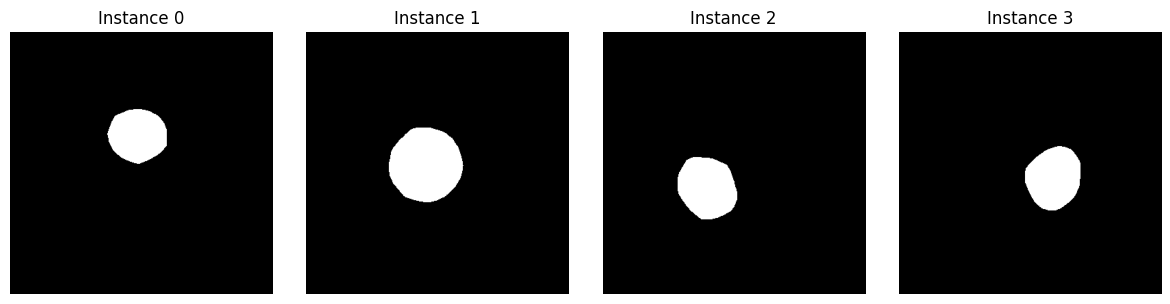

In [15]:
visualize_instance_masks(mask_labels)

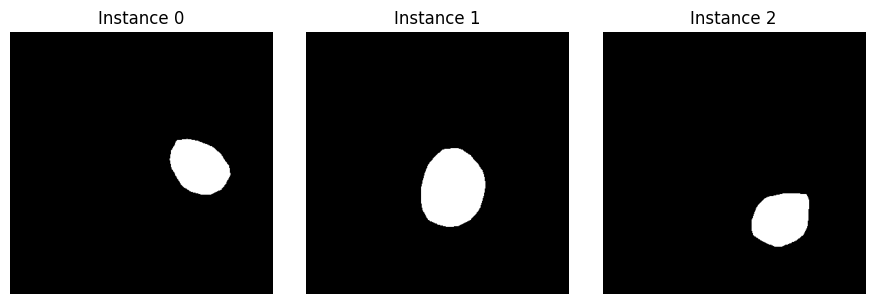

In [17]:
visualize_instance_masks(mask_labels)

In [18]:
from transformers import Mask2FormerConfig, Mask2FormerForUniversalSegmentation
config = Mask2FormerConfig.from_pretrained("facebook/mask2former-swin-small-coco-instance")
config.num_labels = 1  # update số class

model = Mask2FormerForUniversalSegmentation(config)

In [19]:
outputs = model(batch["pixel_values"],
                class_labels=batch["class_labels"],
                mask_labels=batch["mask_labels"])

In [20]:
outputs['class_queries_logits'].shape

torch.Size([2, 100, 2])

In [21]:
logits = outputs['class_queries_logits']
probs = F.softmax(logits, dim=-1)  # shape: [B, Q, 2]

scores, labels = probs.max(dim=-1)

In [22]:
batch["original_masks"]

[array([[[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]], shape=(800, 800, 4), dtype=uint8),
 array([[[0, 0, 0],
 

In [23]:
labels

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [28]:
import evaluate

metric = evaluate.load("mean_iou")

In [29]:
from transformers import MaskFormerImageProcessor

# Create a preprocessor
preprocessor = MaskFormerImageProcessor(ignore_index=0, reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

In [30]:
for labels in batch["class_labels"]:
    print(labels.shape)

torch.Size([2])
torch.Size([5])


In [32]:
import torch
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

running_loss = 0.0
num_samples = 0
for epoch in range(3):
  print("Epoch:", epoch)
  model.train()
  for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(
          pixel_values=batch["pixel_values"].to(device),
          mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
          class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )

      # Backward propagation
      loss = outputs.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 100 == 0:
        print("Loss:", running_loss/num_samples)

      # Optimization
      optimizer.step()

  model.eval()
  for idx, batch in enumerate(tqdm(test_dataloader)):
    if idx > 5:
      break

    pixel_values = batch["pixel_values"]
    
    # Forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values.to(device))

    # get original images
    original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
    # predict segmentation maps
    predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)

    # get ground truth segmentation maps
    ground_truth_segmentation_maps = batch["original_masks"]

    metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)
  

  print("Mean IoU:", metric.compute(num_labels = len(id2label), ignore_index = 0)['mean_iou'])

Epoch: 0


  0%|          | 0/615 [00:00<?, ?it/s]

Loss: 46.15873336791992
Loss: 29.028580882761737
Loss: 26.89961600422266
Loss: 25.7221657002091
Loss: 25.097546765334588
Loss: 24.15378639655199
Loss: 22.88559500905321


  0%|          | 0/159 [00:00<?, ?it/s]

F:\embryo_dataset\embryo_env\lib\site-packages\datasets\features\image.py:347: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


ValueError: Predictions and/or references don't match the expected format.
Expected format: {'predictions': Image(mode=None, decode=True, id=None), 'references': Image(mode=None, decode=True, id=None)},
Input predictions: [tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'), tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')],
Input references: [array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], shape=(800, 800, 9), dtype=uint8), array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], shape=(800, 800, 7), dtype=uint8)]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [73]:
batch[1]

KeyError: 1

In [50]:
np.unique(batch["original_masks"][0][:,:,1])

array([  0, 255], dtype=uint8)

In [71]:
outputs['class_queries_logits'].shape


torch.Size([2, 100, 2])

In [4]:
import torch
import numpy as np

def prepare_target(masks_np):
    # masks_np: numpy array (H, W, N)
    H, W, N = masks_np.shape
    masks = torch.as_tensor(np.moveaxis(masks_np, -1, 0), dtype=torch.uint8)  # (N, H, W)
    
    boxes = []
    for i in range(N):
        pos = np.where(masks[i].numpy())
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes.append([xmin, ymin, xmax, ymax])
    
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.ones((N,), dtype=torch.int64)  # Nếu tất cả là cùng 1 class
    
    target = {
        "boxes": boxes,
        "labels": labels,
        "masks": masks
    }
    return target


In [5]:
from torchvision.models.detection import maskrcnn_resnet50_fpn

model = maskrcnn_resnet50_fpn(pretrained=False, num_classes=2)  # 1 class + background


F:\embryo_dataset\embryo_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
F:\embryo_dataset\embryo_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
from torch.utils.data import Dataset, DataLoader

class MySegmentationDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        img = self.dataset[idx]['image']
        if isinstance(img, Image.Image):  # kiểm tra nếu là PIL Image
            img = np.array(img)  # chuyển sang numpy array
        img = torch.as_tensor(img, dtype=torch.float32).permute(2, 0, 1) / 255.0
        target = prepare_target(self.dataset[idx]['mask'])
        return img, target

    def __len__(self):
        return len(self.dataset)

# Khởi tạo dataset
dataset = MySegmentationDataset(train_data)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop
model.train()
model = model.to(device)
for epoch in range(num_epochs):
    for images, targets in dataloader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()


NotImplementedError: Could not run 'torchvision::nms' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'torchvision::nms' is only available for these backends: [CPU, Meta, QuantizedCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMTIA, AutogradMeta, Tracer, AutocastCPU, AutocastMTIA, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\cpu\nms_kernel.cpp:112 [kernel]
Meta: registered at /dev/null:214 [kernel]
QuantizedCPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\quantized\cpu\qnms_kernel.cpp:124 [kernel]
BackendSelect: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:194 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:479 [backend fallback]
Functionalize: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\FunctionalizeFallbackKernel.cpp:349 [backend fallback]
Named: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:100 [backend fallback]
AutogradOther: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:63 [backend fallback]
AutogradCPU: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:67 [backend fallback]
AutogradCUDA: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:75 [backend fallback]
AutogradXLA: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:83 [backend fallback]
AutogradMPS: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:91 [backend fallback]
AutogradXPU: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:71 [backend fallback]
AutogradHPU: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:104 [backend fallback]
AutogradLazy: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:87 [backend fallback]
AutogradMTIA: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:79 [backend fallback]
AutogradMeta: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:95 [backend fallback]
Tracer: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\TraceTypeManual.cpp:294 [backend fallback]
AutocastCPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\autocast\nms_kernel.cpp:34 [kernel]
AutocastMTIA: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\autocast_mode.cpp:466 [backend fallback]
AutocastXPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\autocast\nms_kernel.cpp:41 [kernel]
AutocastMPS: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\autocast_mode.cpp:209 [backend fallback]
AutocastCUDA: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\autocast\nms_kernel.cpp:27 [kernel]
FuncTorchBatched: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\TensorWrapper.cpp:208 [backend fallback]
PythonTLSSnapshot: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:202 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:475 [backend fallback]
PreDispatch: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:206 [backend fallback]
PythonDispatcher: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:198 [backend fallback]


In [7]:
dataset[1]

(tensor([[[0.6039, 0.6039, 0.6039,  ..., 0.0000, 0.0000, 0.0000],
          [0.6039, 0.6000, 0.5961,  ..., 0.0000, 0.0000, 0.0000],
          [0.6000, 0.5922, 0.5804,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.6196, 0.6235, 0.6235,  ..., 0.0000, 0.0000, 0.0000],
          [0.6196, 0.6196, 0.6235,  ..., 0.0000, 0.0000, 0.0000],
          [0.6157, 0.6196, 0.6235,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.6039, 0.6039, 0.6039,  ..., 0.0000, 0.0000, 0.0000],
          [0.6039, 0.6000, 0.5961,  ..., 0.0000, 0.0000, 0.0000],
          [0.6000, 0.5922, 0.5804,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.6196, 0.6235, 0.6235,  ..., 0.0000, 0.0000, 0.0000],
          [0.6196, 0.6196, 0.6235,  ..., 0.0000, 0.0000, 0.0000],
          [0.6157, 0.6196, 0.6235,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.6039, 0.6039, 0.6039,  ..., 0.0000, 0.0000, 0.0000],
          [0.6039, 0.6000, 0.5961,  ..., 0.0000, 0.0000, 0.0000],
          [0.6000, 0.5922, 0.5804,  ...,

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
for images, targets in dataloader:
    print(images)
    print(targets)
    break
    

(tensor([[[0.4980, 0.5098, 0.5176,  ..., 0.0000, 0.0000, 0.0000],
         [0.4980, 0.5098, 0.5176,  ..., 0.0000, 0.0000, 0.0000],
         [0.4980, 0.5098, 0.5176,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.5294, 0.5373, 0.5451,  ..., 0.0000, 0.0000, 0.0000],
         [0.5333, 0.5373, 0.5451,  ..., 0.0000, 0.0000, 0.0000],
         [0.5333, 0.5412, 0.5490,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.4980, 0.5098, 0.5176,  ..., 0.0000, 0.0000, 0.0000],
         [0.4980, 0.5098, 0.5176,  ..., 0.0000, 0.0000, 0.0000],
         [0.4980, 0.5098, 0.5176,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.5294, 0.5373, 0.5451,  ..., 0.0000, 0.0000, 0.0000],
         [0.5333, 0.5373, 0.5451,  ..., 0.0000, 0.0000, 0.0000],
         [0.5333, 0.5412, 0.5490,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.4980, 0.5098, 0.5176,  ..., 0.0000, 0.0000, 0.0000],
         [0.4980, 0.5098, 0.5176,  ..., 0.0000, 0.0000, 0.0000],
         [0.4980, 0.5098, 0.5176,  ..., 0.0000, 0.0000, 0

In [1]:
import torch
import torchvision

print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("CUDA:", torch.version.cuda)


ModuleNotFoundError: No module named 'torchvision'

In [3]:
device

device(type='cpu')